In [8]:
from urllib.request import urlopen
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from bs4 import BeautifulSoup
import re
import time
import pandas as pd

In [2]:
html = urlopen('https://fbref.com/en/comps/9/Premier-League-Stats')
bs = BeautifulSoup(html, 'html.parser')

In [3]:
team_a_tag = bs.find_all('a', {'href':re.compile('\/en\/squads\/[a-z0-9]*\/[A-Za-z\-]*\-Stats')})[:20]

team_urls = []
for a_tag in team_a_tag:
    team_urls.append(f"https://fbref.com{a_tag['href']}")

team_urls

['https://fbref.com/en/squads/822bd0ba/Liverpool-Stats',
 'https://fbref.com/en/squads/b8fd03ef/Manchester-City-Stats',
 'https://fbref.com/en/squads/18bb7c10/Arsenal-Stats',
 'https://fbref.com/en/squads/8602292d/Aston-Villa-Stats',
 'https://fbref.com/en/squads/361ca564/Tottenham-Hotspur-Stats',
 'https://fbref.com/en/squads/7c21e445/West-Ham-United-Stats',
 'https://fbref.com/en/squads/d07537b9/Brighton-and-Hove-Albion-Stats',
 'https://fbref.com/en/squads/19538871/Manchester-United-Stats',
 'https://fbref.com/en/squads/cff3d9bb/Chelsea-Stats',
 'https://fbref.com/en/squads/b2b47a98/Newcastle-United-Stats',
 'https://fbref.com/en/squads/8cec06e1/Wolverhampton-Wanderers-Stats',
 'https://fbref.com/en/squads/4ba7cbea/Bournemouth-Stats',
 'https://fbref.com/en/squads/fd962109/Fulham-Stats',
 'https://fbref.com/en/squads/cd051869/Brentford-Stats',
 'https://fbref.com/en/squads/47c64c55/Crystal-Palace-Stats',
 'https://fbref.com/en/squads/e4a775cb/Nottingham-Forest-Stats',
 'https://fbre

In [5]:
from collections import defaultdict
outfield_players = defaultdict(list)
gk_s = defaultdict(list)
team_logos = defaultdict(str)
for url in team_urls:
    html = urlopen(url)
    bs = BeautifulSoup(html, 'html.parser')
    club_name = ' '.join(bs.find('div', {'data-template': 'Partials/Teams/Summary'}).find('span').get_text().split()[1:-1])
    shoot_stat_rows = bs.find('table', {'id':'stats_shooting_9'}).find('tbody').find_all('tr')
    
    gca_stat_rows = bs.find('table', {'id':'stats_gca_9'}).find('tbody').find_all('tr')
    
    pass_stat_rows = bs.find('table', {'id':'stats_passing_9'}).find('tbody').find_all('tr')

    adv_keeper_stat_rows = bs.find('table', {'id':'stats_keeper_adv_9'}).find('tbody').find_all('tr')
    keeper_stat_rows = bs.find('table', {'id':'stats_keeper_9'}).find('tbody').find_all('tr')
    team_logos[club_name] = bs.find('img', {'class': 'teamlogo'})['src']
    for row in shoot_stat_rows:
        position = row.find('td', {'data-stat':'position'}).get_text()
        if position != 'GK':
            name = row.find('th').get_text()
            position = row.find('td', {'data-stat':'position'}).get_text()
            minutes_90s = row.find('td', {'data-stat':'minutes_90s'}).get_text()
            goals = row.find('td', {'data-stat':'goals'}).get_text()
            pens_made = row.find('td', {'data-stat':'pens_made'}).get_text()
            xg = row.find('td', {'data-stat':'xg'}).get_text()
            npxg = row.find('td', {'data-stat':'npxg'}).get_text()
            outfield_players[name] = [name, position, club_name, minutes_90s, goals, pens_made, xg, npxg]
    for row in pass_stat_rows:
        position = row.find('td', {'data-stat':'position'}).get_text()
        if position != 'GK':
            name = row.find('th').get_text()
            assists = row.find('td', {'data-stat':'assists'}).get_text()
            xg_assist = row.find('td', {'data-stat':'xg_assist'}).get_text()
            outfield_players[name].extend([assists, xg_assist])
    for row in gca_stat_rows:
        position = row.find('td', {'data-stat':'position'}).get_text()
        if position != 'GK':
            name = row.find('th').get_text()
            sca = row.find('td', {'data-stat':'sca'}).get_text()
            outfield_players[name].append(sca)
    
    for row in adv_keeper_stat_rows:
        name = row.find('th').get_text()
        position = row.find('td', {'data-stat':'position'}).get_text()
        minutes_90s = row.find('td', {'data-stat':'minutes_90s'}).get_text()
        goals_against = row.find('td', {'data-stat':'gk_goals_against'}).get_text()
        pens_allowed = row.find('td', {'data-stat':'gk_pens_allowed'}).get_text()
        own_goals_against = row.find('td', {'data-stat':'gk_own_goals_against'}).get_text()
        psnpxg_per_shot_on_target_against = row.find('td', {'data-stat':'gk_psnpxg_per_shot_on_target_against'}).get_text()
        psxg_net = row.find('td', {'data-stat':'gk_psxg_net'}).get_text()
        psxg = row.find('td', {'data-stat':'gk_psxg'}).get_text()
        gk_s[name] = [name, position, club_name, minutes_90s, goals_against, pens_allowed, own_goals_against, psnpxg_per_shot_on_target_against, psxg_net, psxg]
        
    for row in keeper_stat_rows:
        name = row.find('th').get_text()
        clean_sheets = row.find('td', {'data-stat':'gk_clean_sheets'}).get_text()
        gk_s[name].append(clean_sheets)
    time.sleep(4)


In [9]:
outfield_players_data = [value for value in list(outfield_players.values())]
outfield_df = pd.DataFrame(outfield_players_data, columns = ['name', 'position', 'club_name', 'minutes_90s', 'goals', 'pens_made', 'xg', 'npxg', 'assists', 'xg_assist', 'sca'])

In [10]:
float_dt = ['minutes_90s', 'xg', 'npxg', 'xg_assist']
int_dt = ['goals', 'pens_made', 'sca']

outfield_df[float_dt] = outfield_df[float_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0.0).astype(float))
outfield_df[int_dt] = outfield_df[int_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0).astype(int))

In [11]:
gk_data = [value for value in list(gk_s.values())]
gk_df = pd.DataFrame(gk_data, columns = ['name', 'position', 'club_name', 'minutes_90s', 'goals_against', 'pens_allowed', 'own_goals_against', 'psnpxg_per_shot_on_target_against', 'psxg_net', 'psxg', 'clean_sheets'])

In [12]:
float_dt = ['minutes_90s', 'psnpxg_per_shot_on_target_against', 'psxg_net', 'psxg', ]
int_dt = ['goals_against', 'pens_allowed', 'own_goals_against', 'clean_sheets']

gk_df[float_dt] = gk_df[float_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0.0).astype(float))
gk_df[int_dt] = gk_df[int_dt].apply(lambda x: pd.to_numeric(x, errors='coerce').fillna(0).astype(int))

In [13]:
gk_df.groupby('club_name')[['goals_against','clean_sheets']].sum().reset_index()

,club_name,goals_against,clean_sheets
0,Arsenal,20,8
1,Aston Villa,27,5
2,Bournemouth,39,5
3,Brentford,33,3
4,Brighton & Hove Albion,33,2
5,Burnley,42,2
6,Chelsea,31,5
7,Crystal Palace,34,5
8,Everton,28,7
9,Fulham,36,5


In [14]:
response = requests.get('https://cdn.ssref.net/req/202312151/tlogo/fb/822bd0ba.png')
img = Image.open(BytesIO(response.content))

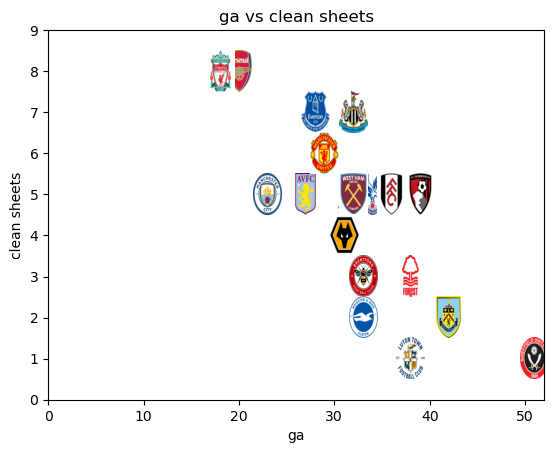

In [15]:
# Example data
df = gk_df.groupby('club_name')[['goals_against','clean_sheets']].sum().reset_index()

# Create the scatter plot
fig, ax = plt.subplots()
ax.set_xlim(0, max(df['goals_against']) + 1)
ax.set_ylim(0, max(df['clean_sheets']) + 1)

ax.set_title('ga vs clean sheets')
ax.set_xlabel('ga')
ax.set_ylabel('clean sheets')

# Adding each team logo as a point on the scatter plot
for i in range(len(df)):
    team = df.loc[i, 'club_name']
    x = df.loc[i, 'goals_against']
    y = df.loc[i, 'clean_sheets']

    # Load the team logo
    response = requests.get(team_logos[team])
    img = Image.open(BytesIO(response.content))

    # Place the image on the plot
    ax.imshow(img, aspect='auto', extent=(x-1.5, x+1.5, y-0.5, y+0.5))

plt.show()